In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

# Mixture density networks (MDN)

Interesting material:

- Bishop pattern recognition and machine learning: Mixture Density Networks page 272
- https://amjadmahayri.wordpress.com/2014/04/30/mixture-density-networks/
- http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/
- http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42020.pdf
- http://eprints.aston.ac.uk/373/1/NCRG_94_004.pdf
- Implementation numpy: https://github.com/karpathy/randomfun/blob/master/MixtureDensityNets.ipynb

#### Draw neural net 
- https://gist.github.com/craffel/2d727968c3aaebd10359

#### What is the advantage of a mixture density network ?

 Instead of using the NN to predict directly the targets, use it to predict the parameters of a conditional distribution over the targets (given the input).
 
- **Mixture density networks learn for each input a conditional distribution over the target**, each has the same form, but with different parameters. 

For example, we can assume that the target has a Gaussian conditional distribution, and the network predicts the mean of this distribution (we assume here that the variance is independent of the input, but this assumption be relaxed).

If we train the network with the mean-squared error loss function we get the same solution as when we train it with the negative log-likelihood of a Gaussian. One might hope that we learn a more complex (multi-modal) conditional distribution for the target. This is actually the goal of Mixture density networks!

We want to model the conditional distribution as a mixture of Gaussians, where each Gaussian component parameters are dependent on the input, that is 

\begin{equation}
P(y^m \mid x^m) = \sum_{k=1}^K \pi_k(x^m) \mathcal{N} \left( y^m \mid \mu_k(x^m) , \sigma_k^2(x^m) \right)
\end{equation}

This network has 3 types of outputs:

- A mixing coefficient $\pi_k$
- The mean of the Gaussian component $\mu_k$
- The variance of the Gaussian component $\sigma_k^2$

One might think: we don’t have ground truths for those outputs $\pi_k,\mu_k, \sigma_k^2$ , how could make the network learn them?! the answer is we don’t need ground truths, because the loss function we’re going to use is the negative log likelihood given the data, so we just update the parameters of the model as to minimize this loss function.

#### Implementation of the mixture density network:

Implementation of the mixture density network: https://github.com/aalmah/ift6266amjad/blob/master/experiments/mdn.py

This implementation

- Accepts multiple samples at once. Therefore Gaussian components are multivariate.
- Supports mini batches of data.
- $\mu$ is a 3d tensor

Notice that the output layer is a bit different with respect to an standard MLP. The standard MLP uses a matrix as output layer for any regression problem. This network has in the output layer

- A tensor for $\mu$
- A matrix for $\sigma^2$
- A matrix for $\pi$

Notice that

- The activation function for $\mu$ is the same as the desired output.
- The activation function for $\sigma^2$ is a softplus.
- The activation function for $\pi$ is a softmax.

#### About NANS and the LogSumExp trick

A straight implementation of MDN would cause a lot of NaNs.
**A very important issue when implementing MDN is that you have the log-sum-exp expression in the log likelihood**, which otherwise can be numerically unstable. This can be fixed using this trick (https://github.com/Theano/Theano/issues/1563).

 We have to use a **smaller initial learning rate than a the one I used in my previous MLP is important**, otherwise we would get NaN in the likelihood. 
 
 With these two tricks, we don’t get any NaNs. For the RNADE paper trick, I tried multiplying the mean with the variance in the cost function, but this changes the gradients of the variance and it makes the performance worse. In addition, I didn’t find it helping at all.
 
 Multiplying the gradient of the \mu directly with the \sigma is a little tricky when you’re using Theano’s automatic differentiation, and that’s probably why when I checked the RNADE code I found that they’re computing the gradients without using Theano’s T.grad
 
 
 
#### Experiments 

- We would like to compare the MDN model with a similar MLP, and we can compare them in terms of the mean negative log-likelihood (Mean NLL) and the MSE on the same set of validation set.


- In order to compute the MSE for the MDN model, we need to sample from the target conditional distribution. We do that by doing the following for each input data point: 
    - we sample the component from the multinomial distribution over the components (parametrized by the mixing coefficients), which gives us a selected component, 
    - then sample the prediction from the selected Gaussian component. 


- Computing the log-likelihood of the MLP is easy, it’s just the log of a Gaussian, with the output of the network as the mean, and its variance is the maximum likelihood estimate from the data, which turns out to be the MSE.



In [37]:
#### Code from A.Karpathy

## Numpy code

In [2]:
import h5py
import scipy
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

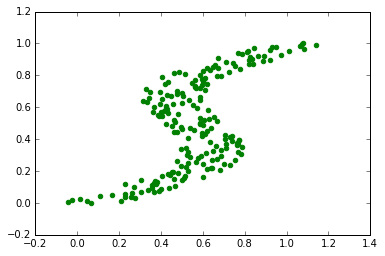

In [39]:
# generate some 1D regression data (reproducing Bishop book data, page 273). 
# Note that the P(y|x) is not a nice distribution. E.g. it has three modes for x ~= 0.5
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.2, N)
X,Y = Y,X
plt.scatter(X,Y,color='g')

In [48]:
# model intialization
input_size = 1
hidden_size = 30
K = 4 # number of mixture components
m = {}
m['Wxh'] = np.random.randn(hidden_size, input_size) * 0.1 # input to hidden
m['Whu'] = np.random.randn(K, hidden_size) * 0.1 # hidden to means
m['Whs'] = np.random.randn(K, hidden_size) * 0.1 # hidden to log standard deviations
m['Whp'] = np.random.randn(K, hidden_size) * 0.1 # hidden to mixing coefficients (cluster priors)
m['bxh'] = np.random.randn(hidden_size, 1) * 0.01
m['bhu'] = np.random.randn(K, 1) * 0.01
m['bhs'] = np.random.randn(K, 1) * 0.01
m['bhp'] = np.random.randn(K, 1) * 0.01

In [49]:
def softmax(x):
    # softmaxes the columns of x
    #z = x - np.max(x, axis=0, keepdims=True) # for safety
    e = np.exp(x)
    en = e / np.sum(e, axis=0, keepdims=True)
    return en

def mdn_loss(x, y, m):
    # data in X are columns
    
    # forward pass
    h = np.tanh(np.dot(m['Wxh'], x) + m['bxh'])
    
    # predict mean
    mu = np.dot(m['Whu'], h) + m['bhu']
    
    # predict log variance
    logsig = np.dot(m['Whs'], h) + m['bhs']
    sig = np.exp(logsig)
    
    # predict mixture priors
    piu = np.dot(m['Whp'], h) + m['bhp'] # unnormalized pi
    pi = softmax(piu)
    
    # compute the loss: mean negative data log likelihood
    k,n = mu.shape # number of mixture components
    ps = np.exp(-((y - mu)**2)/(2*sig**2))/(sig*np.sqrt(2*math.pi))
    pin = ps * pi
    lp = -np.log(np.sum(pin, axis=0, keepdims=True))
    loss = np.sum(lp)/n
    
    # compute the gradients on nn outputsmi
    grad = {}
    gammas = pin / np.sum(pin, axis=0, keepdims = True)
    dmu = gammas * ((mu - y)/sig**2) /n
    dlogsig = gammas * (1.0 - (y-mu)**2/(sig**2)) /n
    dpiu = (pi - gammas) /n
    
    # backprop to decoder matrices
    grad['bhu'] = np.sum(dmu, axis=1, keepdims=True)
    grad['bhs'] = np.sum(dlogsig, axis=1, keepdims=True)
    grad['bhp'] = np.sum(dpiu, axis=1, keepdims=True)
    grad['Whu'] = np.dot(dmu, h.T)
    grad['Whs'] = np.dot(dlogsig, h.T)
    grad['Whp'] = np.dot(dpiu, h.T)
    
    # backprop to h
    dh = np.dot(m['Whu'].T, dmu) + np.dot(m['Whs'].T, dlogsig) + np.dot(m['Whp'].T, dpiu)
    
    # backprop tanh
    dh = (1.0-h**2)*dh
    
    # backprop input to hidden
    grad['bxh'] = np.sum(dh, axis=1, keepdims=True)
    grad['Wxh'] = np.dot(dh, x.T)
    
    # misc stats
    stats = {}
    stats['lp'] = lp
    return loss, grad, stats
    

In [50]:
# utility function for creating contour plot of the predictions
def drawContour(m):
    n = 50
    xx = np.linspace(0,1,n)
    yy = np.linspace(0,1,n)
    xm, ym = np.meshgrid(xx, yy)
    _, _, stats = mdn_loss(xm.reshape(1, xm.size), ym.reshape(1, ym.size), m)
    logps = stats['lp']
    plt.figure(figsize=(10,10))
    plt.scatter(X,Y,color='g')
    lp = stats['lp']
    plt.contour(xm, ym, np.reshape(logps, (n, n)), levels=np.linspace(lp.min(), lp.max(), 50))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('3-component Gaussian Mixture Model for P(y|x)')
#drawContour(m)

In [51]:
nb = N # full batch
xbatch = np.reshape(X[:nb], (1,nb))
ybatch = np.reshape(Y[:nb], (1,nb))

In [52]:
xbatch.T.shape

(200, 1)

In [53]:
# optimize
lr = 1e-2
mem = {}
for k in m.keys(): mem[k] = np.zeros_like(m[k]) # init adagrad
for k in range(20000):
    loss, grad, stats = mdn_loss(xbatch, ybatch, m)
    if k % 1000 == 0:
        print (k, ": ", loss)
        
    for k,v in grad.items():
        mem[k] += grad[k]**2
        m[k] += -lr * grad[k] / np.sqrt(mem[k] + 1e-8)
        

0 :  1.12835865866
1000 :  -0.619901347677
2000 :  -0.678088392091
3000 :  -0.698869443995
4000 :  -0.7112852975
5000 :  -0.746803180041
6000 :  -0.762922948877
7000 :  -0.774175553247
8000 :  -0.78124100375
9000 :  -0.784721518871
10000 :  -0.78739655612
11000 :  -0.791416092591
12000 :  -0.794623719526
13000 :  -0.797117924216
14000 :  -0.799277621277
15000 :  -0.8010991399
16000 :  -0.802686962708
17000 :  -0.804057996381
18000 :  -0.805206310506
19000 :  -0.80623292875


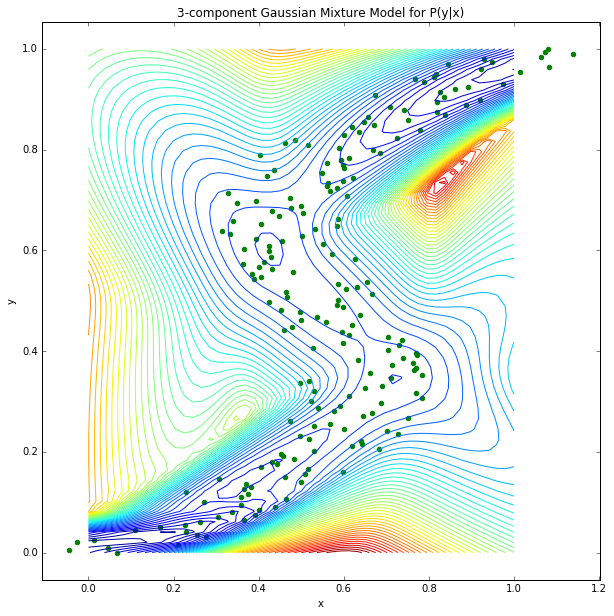

In [54]:
drawContour(m)

In [64]:
def wrapCost(batch, model):
    loss, grad, stats = mdn_loss(batch[0], batch[1], model)
    cg = {}
    cg['grad'] = grad
    cg['cost'] = {}
    cg['cost']['total_cost'] = loss
    return cg

def gradCheck(batch, model, cost_function, **kwargs):
    num_checks = kwargs.get('num_checks', 10)
    delta = kwargs.get('delta', 1e-5)
    rel_error_thr_warning = kwargs.get('rel_error_thr_warning', 1e-2)
    rel_error_thr_error = kwargs.get('rel_error_thr_error', 1)

    cg = cost_function(batch, model)

    print ('running gradient check...')
    for p in model.keys():
      print('checking gradient on parameter',p,'of shape ...', str(model[p].shape))
      mat = model[p]

      s0 = cg['grad'][p].shape
      s1 = mat.shape
      #assert s0 == s1, 'Error dims dont match on %s: grad: %s vs. param: %s.' % (p, `s0`, `s1`)

      for i in range(num_checks):
        #ri = randi(mat.size)
        ri = np.random.randint(0, mat.size)

        # evluate cost at [x + delta] and [x - delta]
        old_val = mat.flat[ri]
        mat.flat[ri] = old_val + delta
        cg0 = cost_function(batch, model)
        mat.flat[ri] = old_val - delta
        cg1 = cost_function(batch, model)
        mat.flat[ri] = old_val # reset old value for this parameter

        # fetch both numerical and analytic gradient
        grad_analytic = cg['grad'][p].flat[ri]
        grad_numerical = (cg0['cost']['total_cost'] - cg1['cost']['total_cost']) / ( 2 * delta )

        # compare them
        if grad_numerical == 0 and grad_analytic == 0:
          rel_error = 0 # both are zero, OK.
          status = 'OK'
        elif abs(grad_numerical) < 1e-7 and abs(grad_analytic) < 1e-7:
          rel_error = 0 # not enough precision to check this
          status = 'VAL SMALL WARNING'
        else:
          rel_error = abs(grad_analytic - grad_numerical) / abs(grad_numerical + grad_analytic)
          status = 'OK'
          if rel_error > rel_error_thr_warning: status = 'WARNING'
          if rel_error > rel_error_thr_error: status = '!!!!! NOTOK'

        # print stats
        #print '%s %s index %8d (val = %+8f), analytic = %+8f, numerical = %+8f, rel error = %+8f' \
        #      % (status, p, ri, old_val, grad_analytic, grad_numerical, rel_error)
            
gradCheck((xbatch, ybatch), m, wrapCost)

running gradient check...
checking gradient on parameter Wxh of shape ... (30, 1)
checking gradient on parameter bhu of shape ... (4, 1)
checking gradient on parameter bxh of shape ... (30, 1)
checking gradient on parameter Whp of shape ... (4, 30)
checking gradient on parameter Whu of shape ... (4, 30)
checking gradient on parameter bhp of shape ... (4, 1)
checking gradient on parameter Whs of shape ... (4, 30)
checking gradient on parameter bhs of shape ... (4, 1)
